<a href="https://colab.research.google.com/github/tekebim/python-render-session/blob/master/Analyse_Olympics_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des jeux olympiques depuis 120 ans
---
Depuis les éditions d'Athènes en 1896 jusqu'à celle de Rio 2016





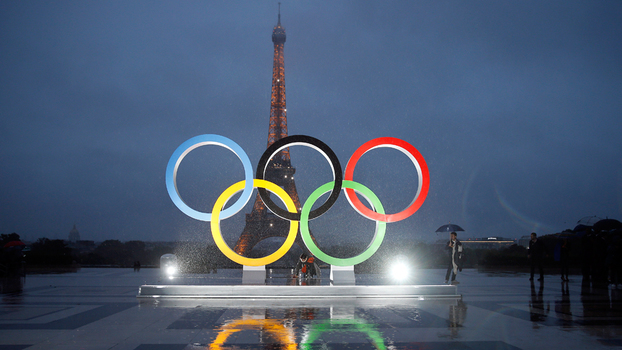

In [182]:
# import libraires
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter

sns.set(style="darkgrid")

# import google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/Colab Notebooks'
regions = pd.read_csv(root_path+'/data/noc_regions.csv', sep=',')
athletes = pd.read_csv(root_path+'/data/athlete_events.csv', sep=',')

regions.info()
athletes.info()

Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  S

Le dataset "athletes" contient 271116 entrées réparties dans 15 colonnes avec des valeurs de types ( object, int64 et float64)

Les colonnes correspondent à:
 - **ID**: ID unique
 - **Name**: le nom de l'athlète
 - **Sex**: le sexe de l'athlète
 - **Age** : l'age de l'athlète <span style="color:red">**au format float**</span>
 - **Height** : la hauteur de l'athlète <span style="color:red">**au format float**</span> en cm
 - **Weight** : le poids de l'athlète <span style="color:red">**au format float**</span> en kg
 - **Team** : l'équipe de l'athlète
 - **NOC** : National Olympic Committee - Code en 3-lettres
 - **Games** : correspond à l'édition des olympiades
 - **Year** : l'année des olympiades
 - **Season** : définit s'il s'agit des JO d'Eté ou d'Hiver
 - **City** : précise la ville dans laquelle les JO se sont déroulés
 - **Sport** : correspond à la discipline sportive de l'athlète
 - **Event** : correspond à la catégorie de la discipline sportive
 - **Medal** : précise si l'athlète à remporter une médaille et si oui, de quel type <span style="color:red">**au format textuel**</span>

In [183]:
# show first entries
athletes.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [184]:
# show last entries
athletes.tail(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN
271115,135571,Tomasz Ireneusz ya,M,34.0,185.0,96.0,Poland,POL,2002 Winter,2002,Winter,Salt Lake City,Bobsleigh,Bobsleigh Men's Four,NaN


In [185]:
# Analyse regions info 
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


In [186]:
# display sample
regions.sample(5)

,NOC,region,notes
210,UAR,Syria,United Arab Republic
180,SLE,Sierra Leone,NaN
158,PHI,Philippines,NaN
174,SAM,Samoa,NaN
116,LBR,Liberia,NaN


In [187]:
# identify null values on dataset
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(athletes)

,Total,Percent
Medal,231333,85.326207
Weight,62875,23.191180
Height,60171,22.193821
Age,9474,3.494445
Event,0,0.000000
Sport,0,0.000000
City,0,0.000000
Season,0,0.000000
Year,0,0.000000
Games,0,0.000000


#### Analyse des valeurs manquantes pour "Medals"
Valeurs NaN dans la colonne "Medal", car cela correspond aux athletes n'ayant pas gagnés de médailles durant les Jeux Olympiques. Nous allons donc remplacer par une valeur par default : "None"

On constate que les données pour la hauteur et le poids des athlètes contiennent respectivement environ 23% de données manquantes. Nous allons donc faire le choix d'injecter la moyenne pour ne pas impacter les données.

On se rend compte que le tableau d'athlètes contient une colonne NOC (pour la valeur du pays). En revanche la valeur n'est pas affiché en entier, nous allons donc fusionner les valeurs en fonction d'un autre dataset : regions

## Merge les deux dataframes

In [188]:
# merge data regions
athletesFull = pd.merge(athletes, regions, on='NOC', how='left')

# display sample value to check
athletesFull.sample(3)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
21648,11435,Samuel Leo Bigler,M,29.0,170.0,82.0,United States,USA,1976 Summer,1976,Summer,Montreal,Weightlifting,Weightlifting Men's Light-Heavyweight,NaN,USA,NaN
211658,106288,Teofil Elek Vilmos Savniky-Marschalk,M,17.0,NaN,NaN,Hungary,HUN,1912 Summer,1912,Summer,Stockholm,Athletics,"Athletics Men's 1,500 metres",NaN,Hungary,NaN
258343,129364,Ludwig Weinacht,M,24.0,NaN,NaN,Berliner Ruderclub Sport-Borussia-1,GER,1912 Summer,1912,Summer,Stockholm,Rowing,Rowing Men's Coxed Eights,NaN,Germany,NaN


In [189]:
# replace value with no result in Medal column
athletesFilter = athletesFull.copy();
athletesFilter['Medal'].fillna('None', inplace = True)
athletesFilter.sample(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
51356,26401,Guy Julien Ernest Delage de Luget,M,40.0,NaN,NaN,France,FRA,1924 Summer,1924,Summer,Paris,Fencing,"Fencing Men's Foil, Team",Gold,France,NaN
209806,105346,Mirko Sandi,M,26.0,198.0,100.0,Yugoslavia,YUG,1968 Summer,1968,Summer,Mexico City,Water Polo,Water Polo Men's Water Polo,Gold,Serbia,Yugoslavia
128154,64544,Satomi Kubokura,F,26.0,160.0,52.0,Japan,JPN,2008 Summer,2008,Summer,Beijing,Athletics,Athletics Women's 400 metres Hurdles,None,Japan,NaN
123381,62348,Dagmara Katarzyna Komorowicz,F,17.0,170.0,54.0,Poland,POL,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 100 metres Backstroke,None,Poland,NaN
192674,96741,Janno Prants,M,28.0,178.0,73.0,Estonia,EST,2002 Winter,2002,Winter,Salt Lake City,Biathlon,Biathlon Men's 10 kilometres Sprint,None,Estonia,NaN


In [190]:
# analyse dtype of age column
print('Champ(s) "Age" vide(s) : ', athletesFilter.Age.isna().sum())
print('Type de données : ', athletesFilter.Age.dtype)

meanAge = athletesFilter.Age.mean()
print('Age moyen : ', meanAge)

# replace all null values with the mean
athletesFilter.Age.fillna(athletesFilter.Age.mean(), inplace = True)
print('Contrôle de champ "Age" vide : ', athletesFilter.Age.isna().sum())

Champ(s) "Age" vide(s) :  9474
Type de données :  float64
Age moyen :  25.556898357297374
Contrôle de champ "Age" vide :  0


Nous avons donc remplacé les valeurs null dans la colonne "Age" par la moyenne de la valeur "Age".

In [238]:
# analyse dtype of age column
meanHeight = athletesFilter.Height.mean()
print('Height moyen : ', meanHeight)

# replace all null values with the mean
athletesFilter.Height.fillna(athletesFilter.Weight.mean(), inplace = True)

meanWeight = athletesFilter.Weight.mean()
print('Weight moyen : ', meanWeight)

# replace all null values with the mean
athletesFilter.Weight.fillna(athletesFilter.Weight.mean(), inplace = True)

Height moyen :  175.33896987366376
Weight moyen :  70.70239290053351


# Analyse des datas

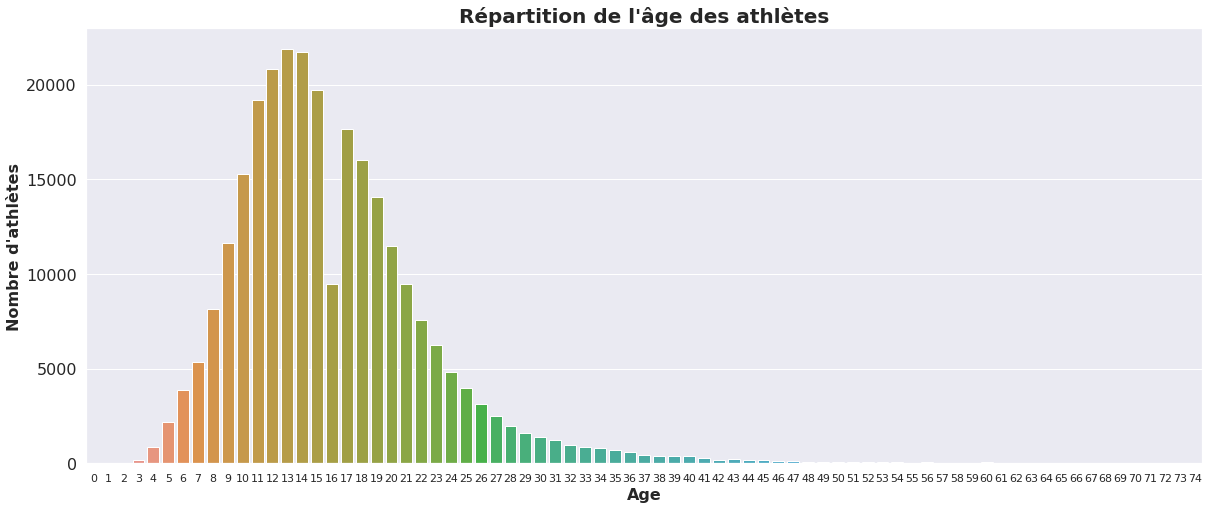

In [191]:
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.countplot(x="Age", data=athletesFilter)
ax.set_title('Répartition de l\'âge des athlètes', fontsize = 20, loc='center',fontdict=dict(weight='bold'))
ax.set_xlabel('Age', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Nombre d\'athlètes', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
# convert x axis to integer instead of float
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

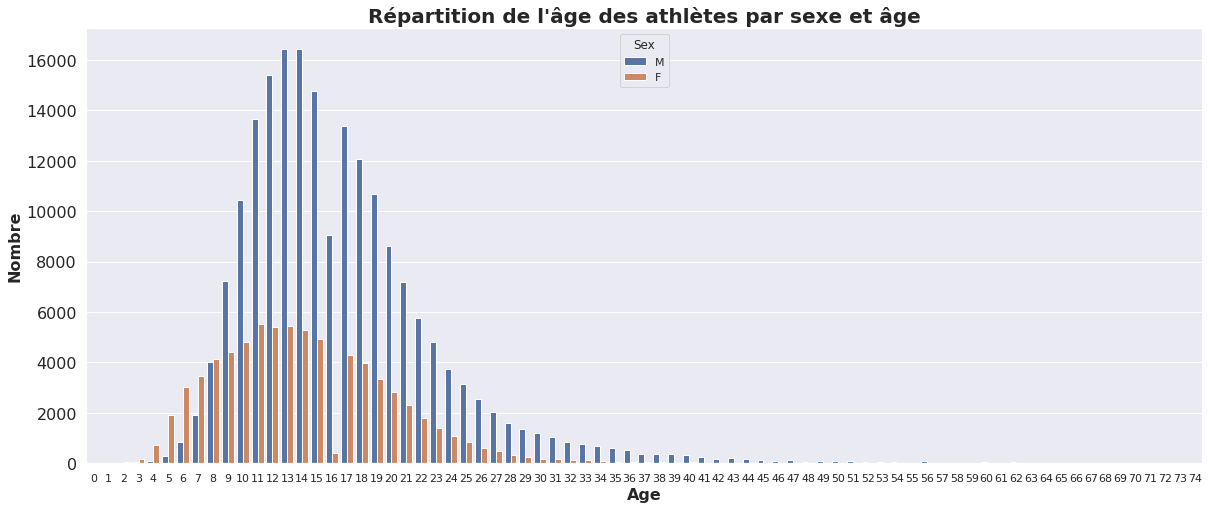

In [192]:
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.countplot(x="Age", hue="Sex", data=athletesFilter)
ax.set_title('Répartition de l\'âge des athlètes par sexe et âge', fontsize = 20, loc='center',fontdict=dict(weight='bold'))
ax.set_xlabel('Age', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Nombre', fontsize = 16, fontdict=dict(weight='bold'))
# ax.set_xlim( 9, 40 )

plt.tick_params(axis='y', which='major', labelsize=16)

# convert x axis to integer instead of float
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

## Analyse de la répartition par sexe

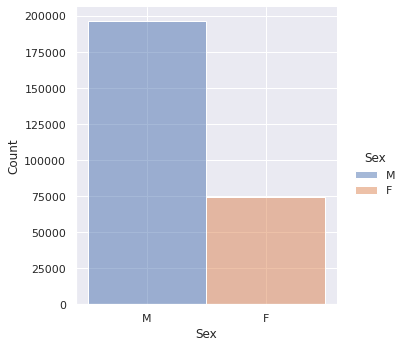

In [193]:
sns.displot(athletesFilter, x="Sex", binwidth=3, hue="Sex")

On constate qu'il y a plus du double d'athlètes homme que d'athlète femme au cours des différentes éditions.

## Le nombre de disciplines totales

In [194]:
sports = athletesFilter['Sport'].unique()
print(len(sports), 'disciplines olympiques :')
sports

66 disciplines olympiques :


array(['Basketball', 'Judo', 'Football', 'Tug-Of-War', 'Speed Skating',
       'Cross Country Skiing', 'Athletics', 'Ice Hockey', 'Swimming',
       'Badminton', 'Sailing', 'Biathlon', 'Gymnastics',
       'Art Competitions', 'Alpine Skiing', 'Handball', 'Weightlifting',
       'Wrestling', 'Luge', 'Water Polo', 'Hockey', 'Rowing', 'Bobsleigh',
       'Fencing', 'Equestrianism', 'Shooting', 'Boxing', 'Taekwondo',
       'Cycling', 'Diving', 'Canoeing', 'Tennis', 'Modern Pentathlon',
       'Figure Skating', 'Golf', 'Softball', 'Archery', 'Volleyball',
       'Synchronized Swimming', 'Table Tennis', 'Nordic Combined',
       'Baseball', 'Rhythmic Gymnastics', 'Freestyle Skiing',
       'Rugby Sevens', 'Trampolining', 'Beach Volleyball', 'Triathlon',
       'Ski Jumping', 'Curling', 'Snowboarding', 'Rugby',
       'Short Track Speed Skating', 'Skeleton', 'Lacrosse', 'Polo',
       'Cricket', 'Racquets', 'Motorboating', 'Military Ski Patrol',
       'Croquet', 'Jeu De Paume', 'Roque', 'Al

## Nombre d'éditions

In [195]:
gamesEdition = athletesFilter['Games'].unique()
gamesEdition

array(['1992 Summer', '2012 Summer', '1920 Summer', '1900 Summer',
       '1988 Winter', '1992 Winter', '1994 Winter', '1932 Summer',
       '2002 Winter', '1952 Summer', '1980 Winter', '2000 Summer',
       '1996 Summer', '1912 Summer', '1924 Summer', '2014 Winter',
       '1948 Summer', '1998 Winter', '2006 Winter', '2008 Summer',
       '2016 Summer', '2004 Summer', '1960 Winter', '1964 Winter',
       '1984 Winter', '1984 Summer', '1968 Summer', '1972 Summer',
       '1988 Summer', '1936 Summer', '1952 Winter', '1956 Winter',
       '1956 Summer', '1960 Summer', '1928 Summer', '1976 Summer',
       '1980 Summer', '1964 Summer', '2010 Winter', '1968 Winter',
       '1906 Summer', '1972 Winter', '1976 Winter', '1924 Winter',
       '1904 Summer', '1928 Winter', '1908 Summer', '1948 Winter',
       '1932 Winter', '1936 Winter', '1896 Summer'], dtype=object)

In [196]:
len(gamesEdition)

51

> Depuis la création des jeux olympiques il y a 66 disciplines différentes et 51 éditions se sont déroulées.

## Nombre de participants aux différentes éditions

Text(0, 0.5, "Nombre d'athlètes")

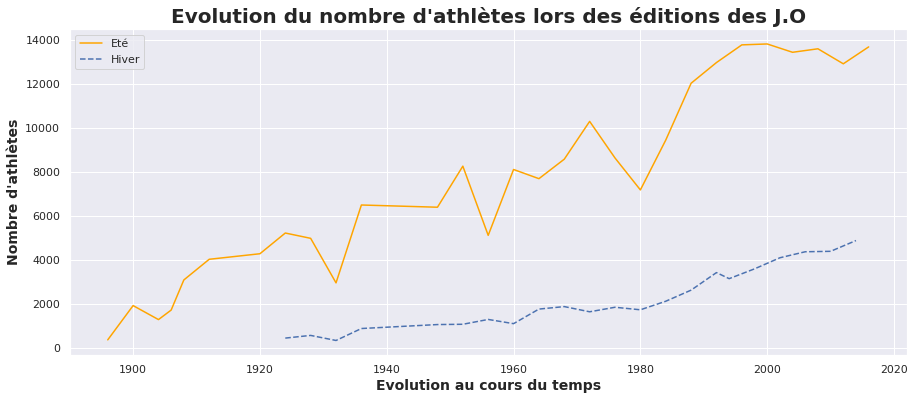

In [197]:
# filter nb athletes for summer edition only
athSummer = athletesFilter[athletesFilter['Season']=='Summer'].groupby('Year')['ID'].count()
# filter nb athletes for winter edition only
athWinter = athletesFilter[athletesFilter['Season']=='Winter'].groupby('Year')['ID'].count()

# draw the figure
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(athSummer, 'orange', label='Eté')
ax.plot(athWinter, '--b', label='Hiver')
leg = ax.legend();

# setup legends
ax.set_title("Evolution du nombre d'athlètes lors des éditions des J.O", fontsize = 20, loc='center',fontdict=dict(weight='bold'))
ax.set_xlabel("Evolution au cours du temps", fontsize = 14, fontdict=dict(weight='bold'))
ax.set_ylabel("Nombre d'athlètes", fontsize = 14, fontdict=dict(weight='bold'))

In [236]:
athletesWinterEdition = athletesFilter[athletesFilter['Season']=='Winter']

In [237]:
athletesSummerEdition = athletesFilter[athletesFilter['Season']=='Summer']

## Evolution du nombre de disciplines

Text(0, 0.5, 'Nombre de disciplines')

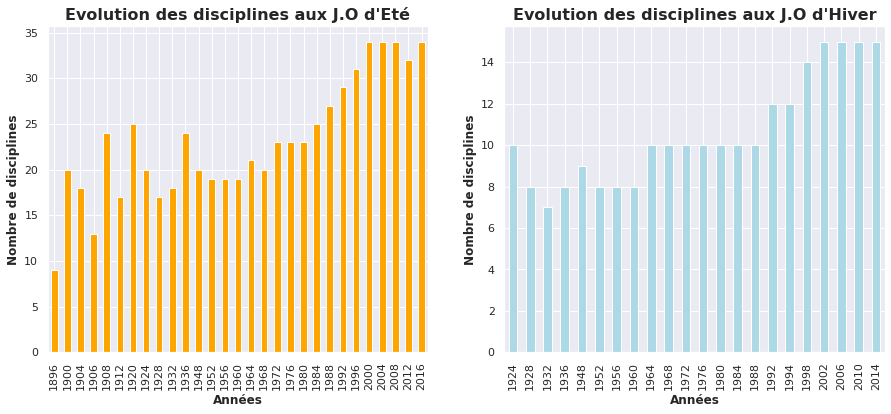

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

athletesSummerEdition.groupby('Year')['Sport'].nunique().plot(kind='bar',ax=ax[0], color='orange')
ax[0].set_title("Evolution des disciplines aux J.O d'Eté", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Nombre de disciplines', fontsize = 12, fontdict=dict(weight='bold'))

athletesWinterEdition.groupby('Year')['Sport'].nunique().plot(kind='bar', ax=ax[1], color='lightblue')
ax[1].set_title("Evolution des disciplines aux J.O d'Hiver", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Nombre de disciplines', fontsize = 12, fontdict=dict(weight='bold'))

In [201]:
# Filtering gold medals
athletesGoldMedals = athletesFilter[(athletesFilter.Medal == 'Gold')]

## Etude des caractéristiques des athlètes

In [202]:
athletesFilter.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,271116.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.280857,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,22.000000,168.000000,60.000000,1960.000000
50%,68205.000000,25.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


> On constate que l'âge moyen d'un athlète est de 25 ans, son poids moyen est de 175cm pour un poids de 70kg.

In [203]:
# track the youngest athlete(s) in gold medals
youngestAthletes = athletesGoldMedals.sort_values(by=['Age'])

## Analyse par pays

In [204]:
# athletes with medals result
athletesMedals = athletesFilter[(athletesFilter.Medal != 'None')]
# athletes with medals result
countriesMedals = athletesMedals[['Team', 'region', 'Medal']]
# athletes with medals gold
countriesGoldMetals= countriesMedals[countriesMedals['Medal'] == 'Gold']

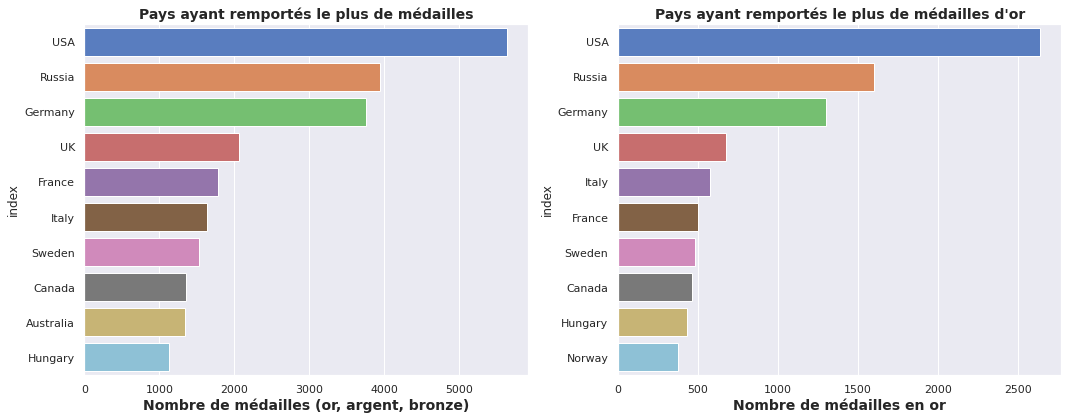

In [205]:
countriesMedalsFilter = countriesMedals.region.value_counts().reset_index(name='Medal').head(10)
countriesGoldMetalsFilter = countriesGoldMetals.region.value_counts().reset_index(name='Medal').head(10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.barplot(x="Medal", y="index" , data=countriesMedalsFilter, palette="muted", ax=ax[0])
sns.barplot(x="Medal", y="index", data=countriesGoldMetalsFilter, palette="muted", ax=ax[1])

ax[0].set_title("Pays ayant remportés le plus de médailles", fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Nombre de médailles (or, argent, bronze)', fontsize = 14, fontdict=dict(weight='bold'))

ax[1].set_title("Pays ayant remportés le plus de médailles d'or", fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Nombre de médailles en or', fontsize = 14, fontdict=dict(weight='bold'))

plt.close(2)
plt.close(3)

fig.tight_layout()

La France se place en 5ème position

In [206]:
regionsParticpating = athletesMedals.region.unique()
print('\033[1m', len(regionsParticpating), 'pays ont participé depuis le début des Jeux Olympiques en 1896 : \033[0m')

regionsParticpating

 137 pays ont participé depuis le début des Jeux Olympiques en 1896 : 


array(['Denmark', 'Finland', 'Norway', 'Netherlands', 'France', 'Italy',
       'Spain', 'Azerbaijan', 'Russia', 'Belarus', 'Cameroon', 'USA',
       'Hungary', 'Greece', 'Australia', 'Iran', 'Canada', 'Pakistan',
       'Uzbekistan', 'Tajikistan', 'Japan', 'Ethiopia', 'Switzerland',
       'Germany', 'Sweden', 'South Africa', 'Turkey', 'Bulgaria', 'Egypt',
       'UK', 'Jordan', 'Romania', 'Puerto Rico', 'Mexico', 'Ghana',
       'Morocco', 'New Zealand', 'Argentina', 'Cuba', 'Uruguay', 'Poland',
       'Czech Republic', 'Nigeria', 'Brazil', 'Austria', 'Lithuania',
       'Indonesia', 'Chile', 'Ukraine', 'Uganda', 'Syria', 'Qatar',
       'Kuwait', 'Individual Olympic Athletes', 'Saudi Arabia',
       'United Arab Emirates', 'Croatia', 'Armenia', 'Serbia', 'Niger',
       'India', 'Belgium', 'Algeria', 'Jamaica', 'Trinidad', 'Colombia',
       'Luxembourg', 'Botswana', 'Tunisia', 'South Korea', 'North Korea',
       'China', 'Guyana', 'Israel', 'Kazakhstan', 'Georgia', 'Kenya',
      

# Analyse plus recentrée (à partir de 1960)

# Analyse des médailles pour la France

In [212]:
frLast30yo = frenchAthletes[frenchAthletes['Year'] >= 1960]
frMedalsLast30yo = frenchAthletesMedals[frenchAthletesMedals['Year'] >= 1960]
frWinnerLast30yo = frMedalsLast30yo[frMedalsLast30yo['Medal'] == "Gold"]

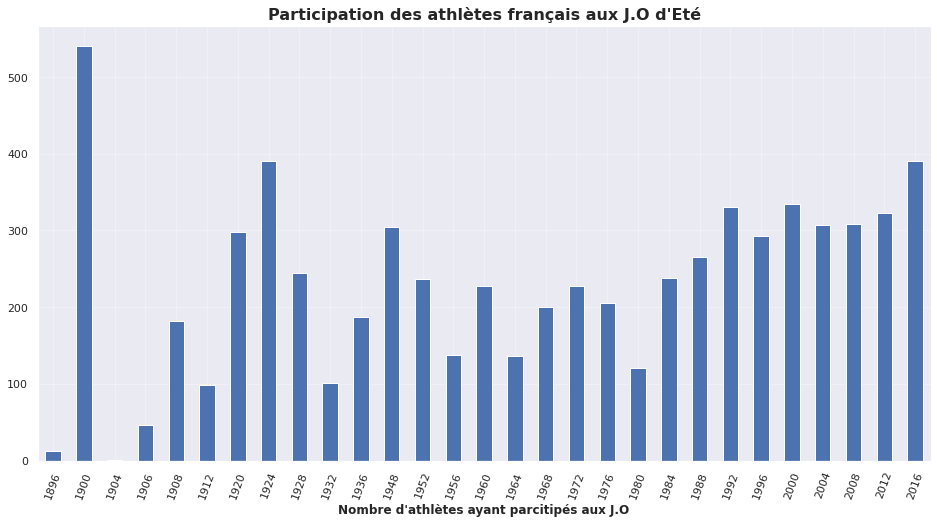

In [213]:
frenchSummerParticipants = athletesSummerEdition[athletesSummerEdition.Team == "France"].loc[:,["ID","Year", "Medal", "Sex", "Sport", "Age"]]

plt.figure(figsize=(16,8))
# nunique : return series with number of distinct observations
franceView = frenchSummerParticipants.groupby("Year")["ID"].nunique().plot(kind = "bar", linewidth = 1)

plt.xticks(rotation = 70)
plt.grid(True,alpha=.3)
plt.title("Participation des athlètes français aux J.O d'Eté", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
plt.xlabel("Nombre d'athlètes ayant parcitipés aux J.O", fontsize = 12, fontdict=dict(weight='bold'))

plt.show()

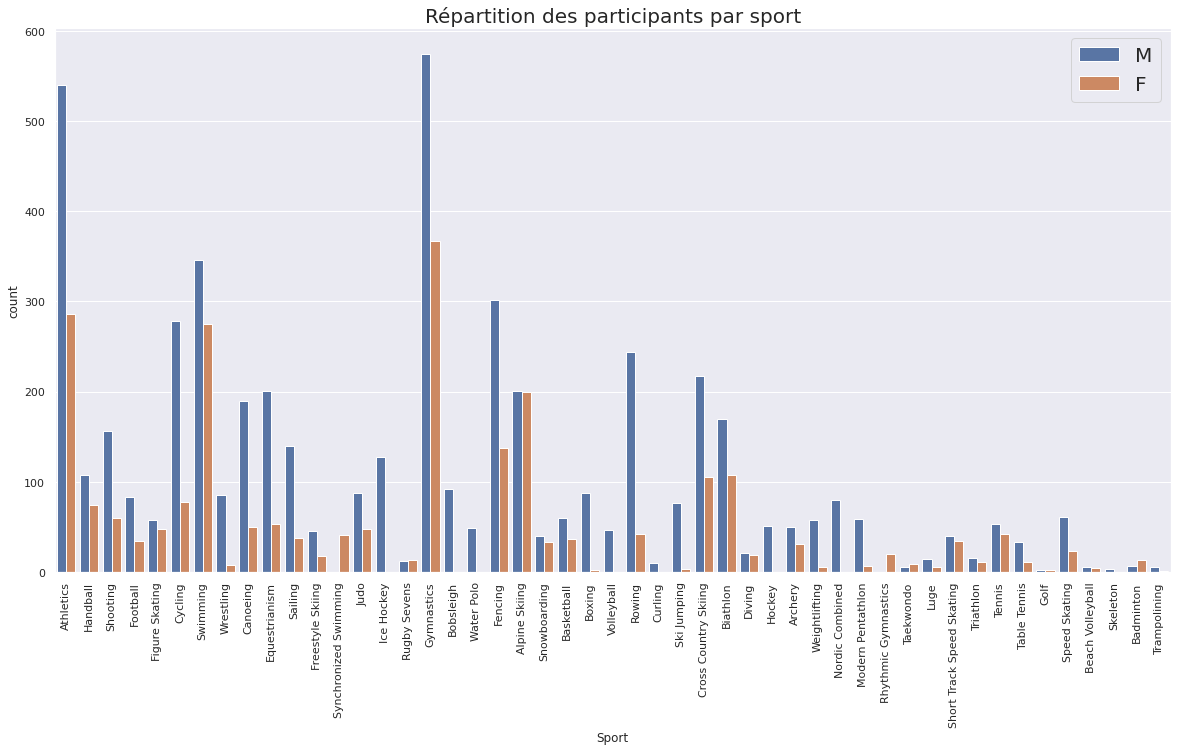

In [214]:
plt.figure(figsize=(20, 10))
sns.countplot(x= 'Sport', hue='Sex', data=frLast30yo)
plt.xticks(rotation = 90)
plt.title('Répartition des participants par sport', fontsize=20)
plt.legend(loc=1, fontsize='20')
plt.show()

On constate qu'il y a plus d'athlètes participants aux éditions parmis les sports suivants : Athlétisme, Natation, Gymanastique, Escrime.

On compte le plus de participants chez les femmes comme chez les hommes pour la discipline : gymnastique.

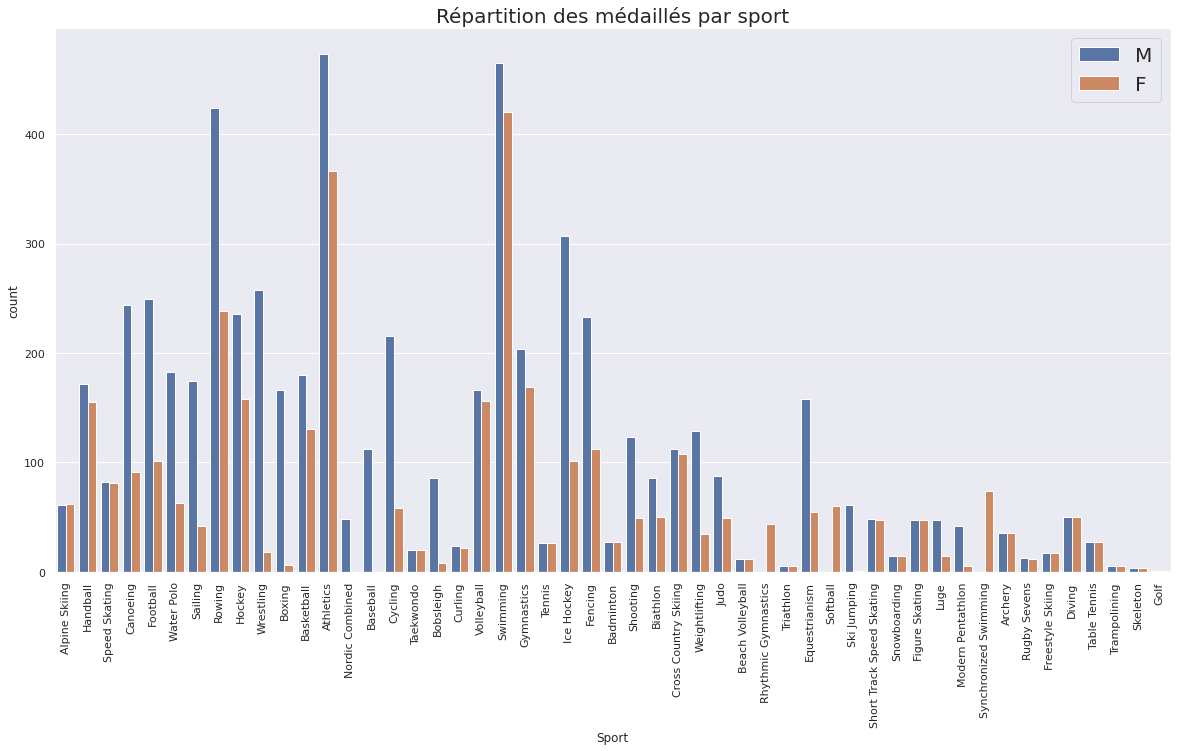

In [215]:
plt.figure(figsize=(20, 10))
sns.countplot(x= 'Sport', hue='Sex', data=frWinnerLast30yo)
plt.xticks(rotation = 90)
plt.title('Répartition des médaillés par sport', fontsize=20)
plt.legend(loc=1, fontsize='20')
plt.show()

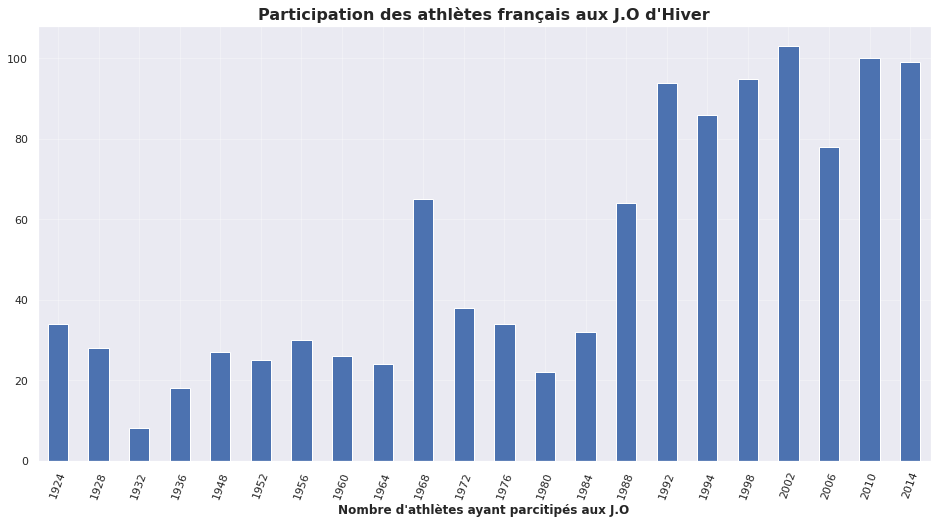

In [216]:
frenchWinterParticipants = athletesWinterEdition[athletesWinterEdition.Team == "France"].loc[:,["ID","Year", "Medal"]]

plt.figure(figsize=(16,8))
# nunique : return series with number of distinct observations
franceView = frenchWinterParticipants.groupby("Year")["ID"].nunique().plot(kind = "bar", linewidth = 1)

plt.xticks(rotation = 70)
plt.grid(True,alpha=.3)
plt.title("Participation des athlètes français aux J.O d'Hiver", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
plt.xlabel("Nombre d'athlètes ayant parcitipés aux J.O", fontsize = 12, fontdict=dict(weight='bold'))

plt.show()

On constate qu'il y a plus d'athlètes français dans les disciplines des J.O d'Eté

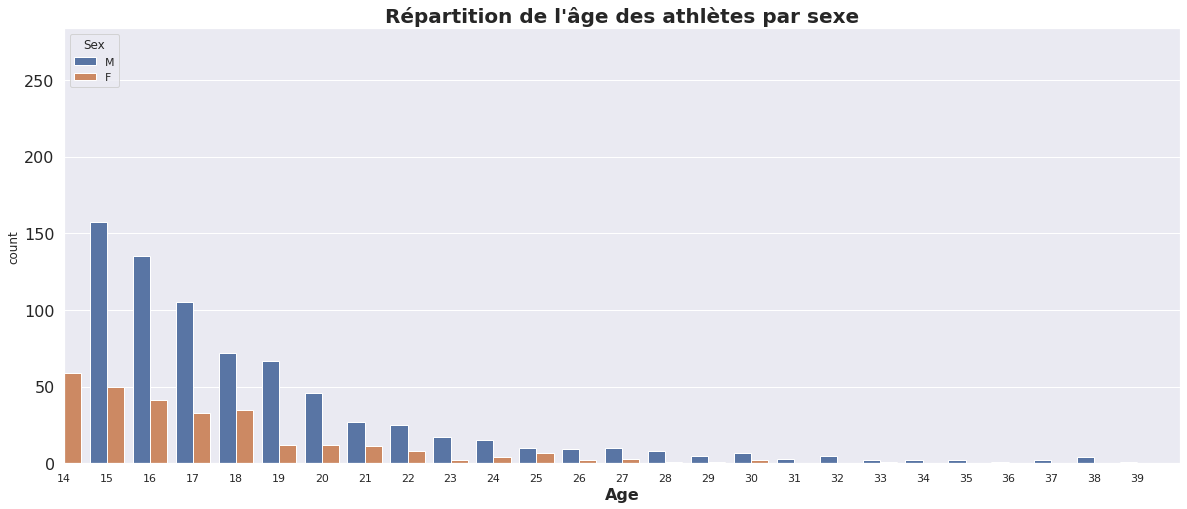

In [217]:
frLast30yoUnique = frLast30yo.drop_duplicates(subset=['Name'])

fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.countplot(x="Age", hue="Sex", data=frLast30yoUnique)
ax.set_title('Répartition de l\'âge des athlètes par sexe', fontsize = 20, loc='center',fontdict=dict(weight='bold'))
ax.set_xlabel('Age', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_xlim( 14, 40 )

plt.tick_params(axis='y', which='major', labelsize=16)

# convert x axis to integer instead of float
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

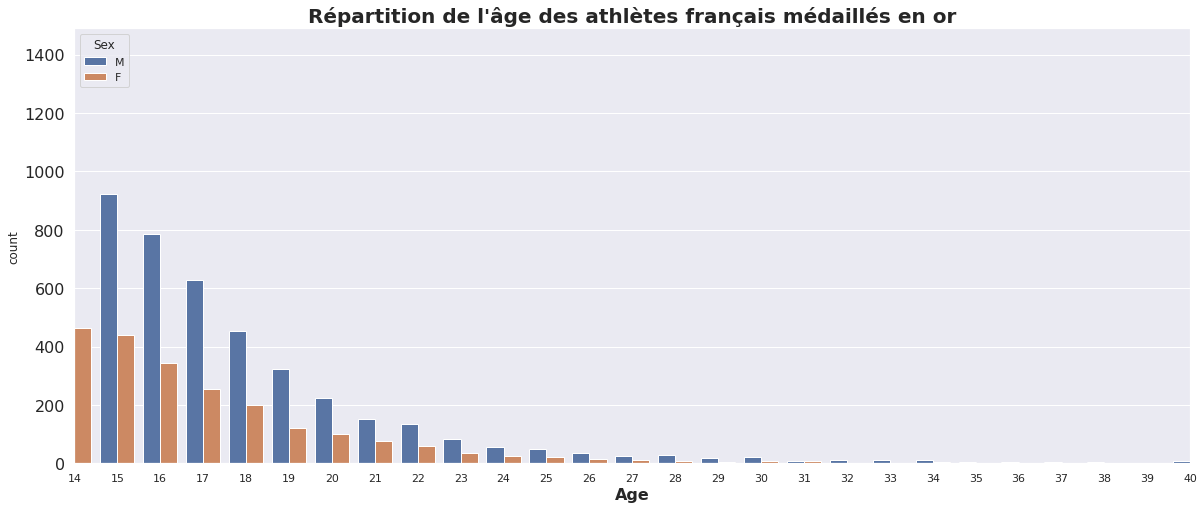

In [218]:
frMedalsLast30yoUnique = frMedalsLast30yo.drop_duplicates(subset=['Name'])

fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.countplot(x="Age", hue="Sex", data=frMedalsLast30yoUnique)
ax.set_title('Répartition de l\'âge des athlètes français médaillés en or', fontsize = 20, loc='center',fontdict=dict(weight='bold'))
ax.set_xlabel('Age', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_xlim( 14, 40 )

plt.tick_params(axis='y', which='major', labelsize=16)

# convert x axis to integer instead of float
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

### Analyse de la répartition des médailles françaises

Text(0, 0.5, 'Nombre de disciplines')

<Figure size 1152x576 with 0 Axes>

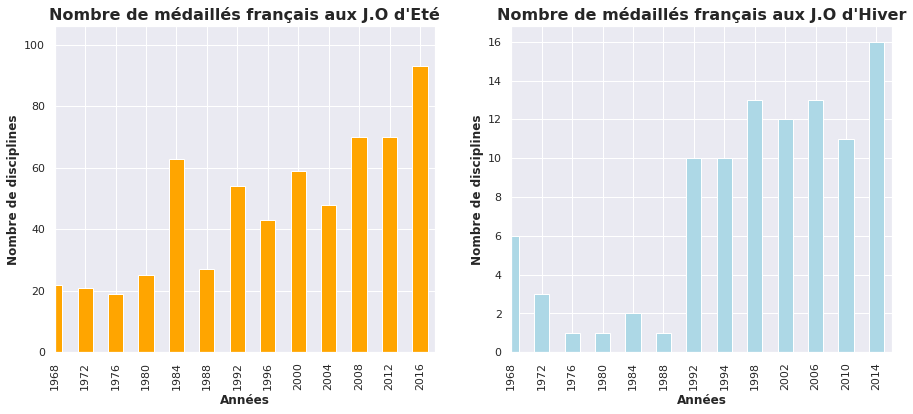

In [219]:
frenchSummerMedals = frenchSummerParticipants[(frenchSummerParticipants.Medal != 'None')]
frenchWinterMedals = frenchWinterParticipants[(frenchWinterParticipants.Medal != 'None')]

plt.figure(figsize=(16,8))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

frenchSummerMedals.groupby("Year")["ID"].nunique().plot(kind = "bar", linewidth = 1, ax=ax[0], color='orange')
ax[0].set_title("Nombre de médaillés français aux J.O d'Eté", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
ax[0].set_xlim(16)
ax[0].set_ylabel('Nombre de disciplines', fontsize = 12, fontdict=dict(weight='bold'))

frenchWinterMedals.groupby("Year")["ID"].nunique().plot(kind = "bar", linewidth = 1, ax=ax[1], color='lightblue')
ax[1].set_title("Nombre de médaillés français aux J.O d'Hiver", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
ax[1].set_xlim(8)
ax[1].set_ylabel('Nombre de disciplines', fontsize = 12, fontdict=dict(weight='bold'))

# Distribution des médailles d'or des athlètes français (toutes éditions confondues)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


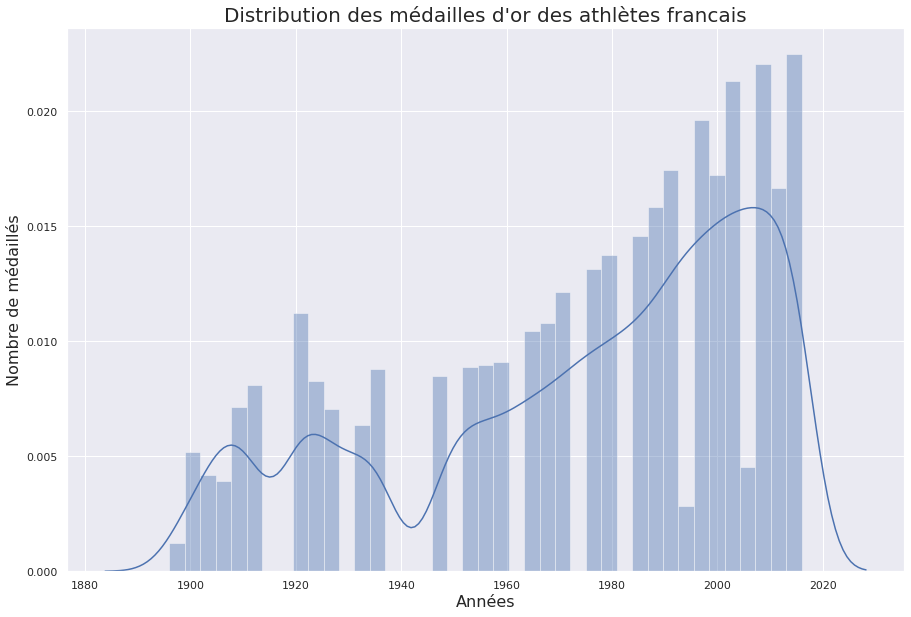

In [220]:
plt.figure(figsize=(15, 10))
sns.distplot(frenchAthletesMedals['Year'])
plt.title("Distribution des médailles d'or des athlètes francais", fontsize = 20)
plt.xlabel('Années', fontsize = 16)
plt.ylabel('Nombre de médaillés', fontsize = 16)
# convert x axis to integer instead of float
plt.show()

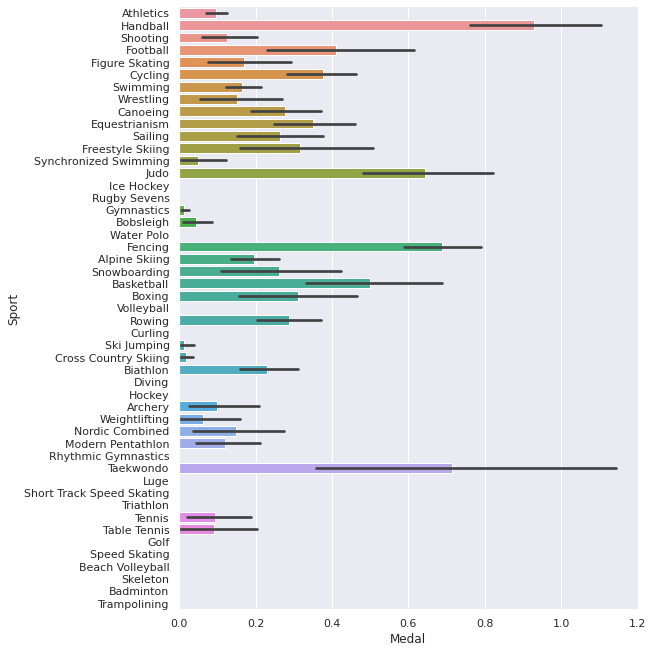

In [221]:
dataSports = frenchAthletes.copy()
# filter since 1960
dataSports = dataSports[dataSports['Year'] >= 1960]
dataSports['Medal'].replace(['None', 'Gold', 'Silver', 'Bronze'], [0, 3, 2, 1], inplace = True)
sns.catplot(x="Medal", y="Sport", data= dataTest, kind="bar", height=9)

Despuis 1960 les sports les plus titrés pour la France sont : le Handball, le Taekwondo, l'Escrime et le Judo.

In [222]:
frenchGoldMedals = frenchAthletes[frenchAthletes['Year'] >= 1960]
frenchGoldMedals = frenchGoldMedals[frenchGoldMedals['Medal'] == "Gold"]
frenchGoldMedals.Event.value_counts().reset_index(name='Medal').head(10)

,index,Medal
0,Handball Men's Handball,30
1,"Fencing Men's epee, Team",21
2,Football Men's Football,16
3,"Fencing Men's Foil, Team",14
4,"Equestrianism Mixed Three-Day Event, Team",9
5,"Equestrianism Mixed Jumping, Team",8
6,Swimming Men's 4 x 100 metres Freestyle Relay,6
7,"Fencing Men's Sabre, Team",6
8,"Fencing Women's Foil, Team",5
9,Judo Men's Heavyweight,5


Les équipes ayant été les plus titrés pour la France sont : Equipe de handball masculin 

In [223]:
# plt.figure(figsize=(20, 20))
# sns.catplot(x="Year", y="Age", data= frenchAthletesMedals, kind="bar", height=5, aspect=3)
# plt.title("'Répartition de l'age des médaillés français")

Text(0, 0.5, 'Nombre de disciplines')

<Figure size 1152x576 with 0 Axes>

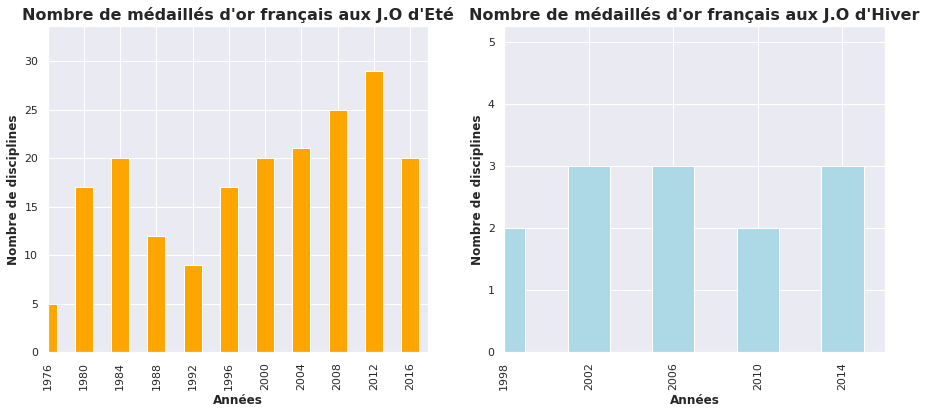

In [224]:
frenchSummerWinner = frenchSummerParticipants[(frenchSummerParticipants.Medal == 'Gold')]
frenchWinterWinner = frenchWinterParticipants[(frenchWinterParticipants.Medal == 'Gold')]

plt.figure(figsize=(16,8))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

frenchSummerWinner.groupby("Year")["ID"].nunique().plot(kind = "bar", linewidth = 1, ax=ax[0], color='orange')
ax[0].set_title("Nombre de médaillés d'or français aux J.O d'Eté", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
ax[0].set_xlim(16)
ax[0].set_ylabel('Nombre de disciplines', fontsize = 12, fontdict=dict(weight='bold'))

frenchWinterWinner.groupby("Year")["ID"].nunique().plot(kind = "bar", linewidth = 1, ax=ax[1], color='lightblue')
ax[1].set_title("Nombre de médaillés d'or français aux J.O d'Hiver", fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Années', fontsize = 12, fontdict=dict(weight='bold'))
ax[1].set_xlim(8)
ax[1].set_ylabel('Nombre de disciplines', fontsize = 12, fontdict=dict(weight='bold'))

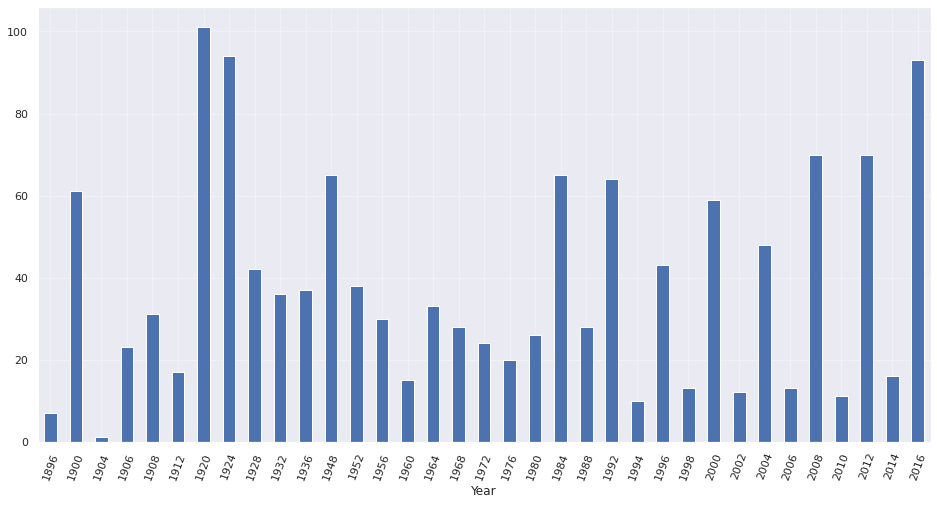

In [231]:
franceMedals = athletesMedals[athletesMedals.Team=="France"]
franceMedals = franceMedals.loc[:,["ID","Year", "Medal"]]

plt.figure(figsize=(16,8))

france = franceMedals.groupby("Year")["ID"].nunique().plot(kind = "bar", linewidth = 1)
# france = franceMedals.groupby("Year")["ID"].nunique().plot(kind = "bar", color = sns.color_palette("husl"), linewidth = 1)

plt.xticks(rotation = 70)
plt.grid(True,alpha=.3)
plt.show()


### Analyse de la répartion des victoires

In [225]:
frWinLast30yo = frenchSummerMedals[frenchSummerMedals['Year'] >= 1960]

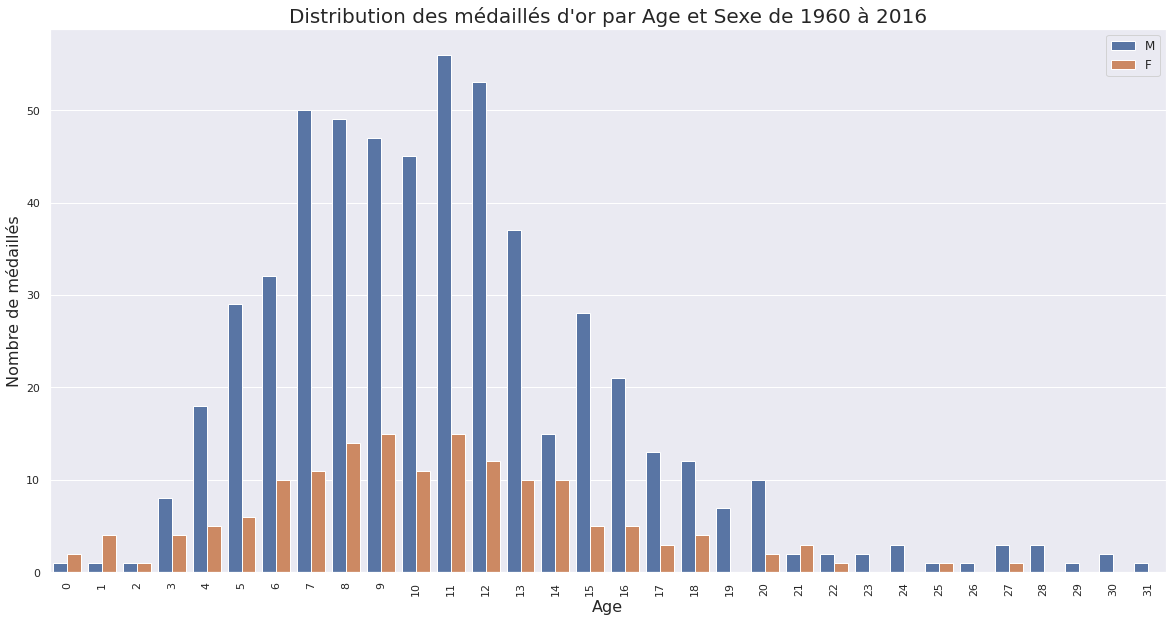

In [226]:
plt.figure(figsize=(20, 10))
sns.countplot(x= 'Age', hue='Sex', data=frWinLast30yo )
plt.xticks(rotation = 90)
plt.legend(loc=1, fontsize='12')
plt.title("Distribution des médaillés d'or par Age et Sexe de 1960 à 2016", fontsize = 20)
plt.xlabel('Age', fontsize = 16)
plt.ylabel('Nombre de médaillés', fontsize = 16)
# convert x axis to integer instead of float
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()

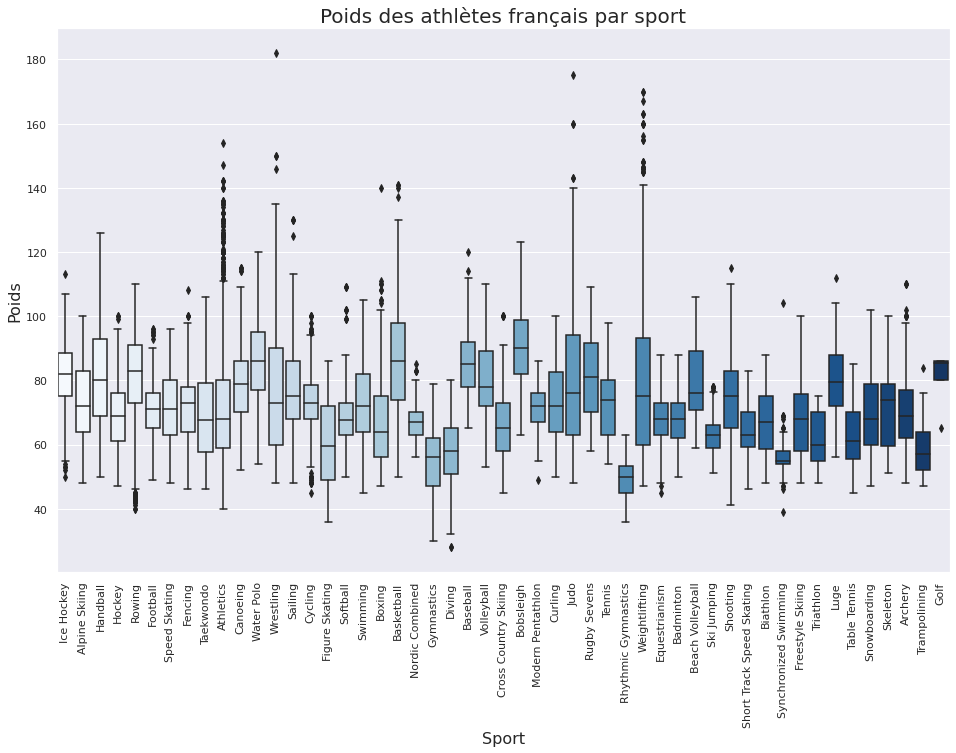

In [239]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='Sport',y='Weight',data=frMedalsLast30yo, palette="Blues")
plt.title("Poids des athlètes français par sport", fontsize = 20)
plt.xlabel('Sport', fontsize = 16)
plt.ylabel('Poids', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

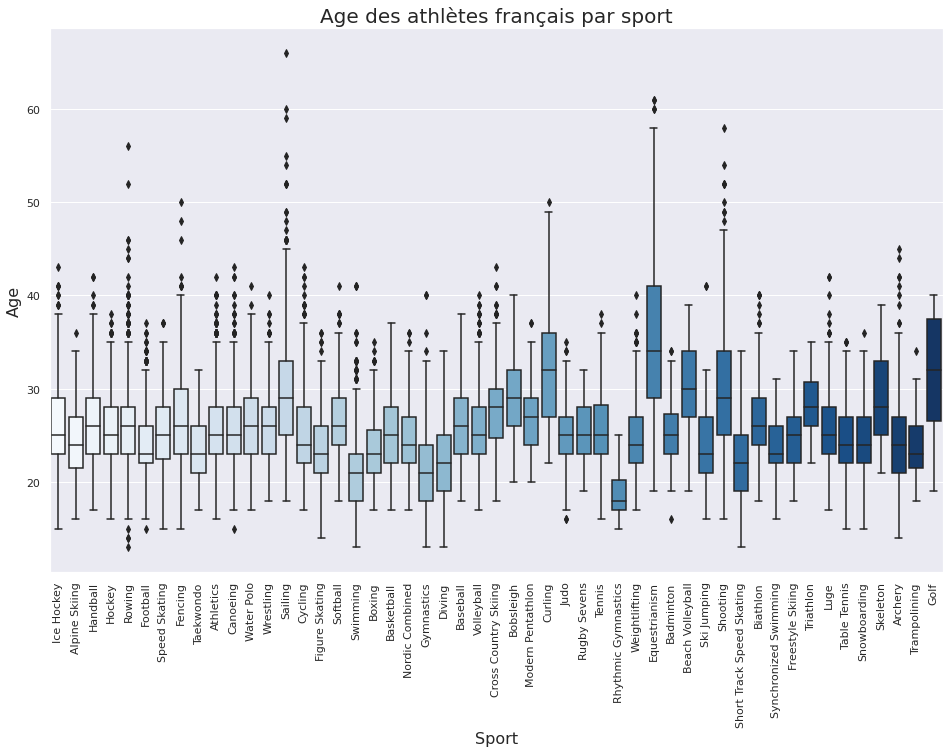

In [240]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='Sport',y='Age',data=frMedalsLast30yo, palette="Blues")
plt.title("Age des athlètes français par sport", fontsize = 20)
plt.xlabel('Sport', fontsize = 16)
plt.ylabel('Age', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

In [232]:
frenchAthletesMedals = athletesFilter[athletesFilter['Medal'] != 'None']
frenchAthletesWinner = athletesFilter[athletesFilter['Medal'] == 'Gold']

In [233]:
dataFiltered = frenchAthletesWinner.loc[:,["Sex", "Age","Height", "Weight", "Team", "Year", "Season", "Sport", "Medal"]]
dataFiltered['Season'].replace(['Summer', 'Winter'], [1, 2], inplace = True)
# dataFiltered['Medal'].replace(['None', 'Gold', 'Silver', 'Bronze'], [1, 2, 3, 4], inplace = True)

In [234]:
matrix = dataFiltered.corr()
matrix

,Age,Height,Weight,Year,Season
Age,1.000000,0.098940,0.176732,-0.092894,0.017920
Height,0.098940,1.000000,0.809500,0.034419,-0.082024
Weight,0.176732,0.809500,1.000000,0.004202,-0.025477
Year,-0.092894,0.034419,0.004202,1.000000,0.153688
Season,0.017920,-0.082024,-0.025477,0.153688,1.000000


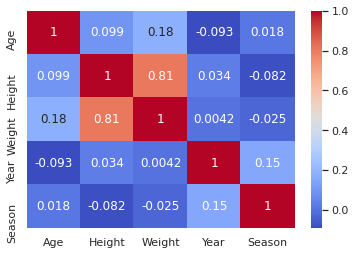

In [235]:
mc = sns.heatmap(matrix, cmap='coolwarm', annot=True)

## Dernière édition en France

In [230]:
lastEditionFR = athletesMedalsWithHost[athletesMedalsWithHost['Country_Host'] == "France"]

---
> Cette analyse de dataset pourrait servir à déterminer des objectifs pour le commité olympique français pour l'édition des jeux olympique d'été à Paris en 2024.

# Analyses des victoires aux éditions "locales"

In [241]:
athletesMedals.City.unique()

array(['Paris', 'Antwerpen', 'Sochi', 'London', 'Helsinki', 'Albertville',
       'Lillehammer', 'Salt Lake City', 'Torino', 'Beijing', 'Seoul',
       'Atlanta', 'Oslo', 'Squaw Valley', 'Stockholm', 'Melbourne',
       'Rio de Janeiro', 'Sydney', 'Athina', 'Moskva', 'Los Angeles',
       'Barcelona', 'Berlin', 'Roma', 'Tokyo', 'Munich', 'Chamonix',
       'St. Louis', 'Sankt Moritz', 'Calgary', 'Grenoble', 'Montreal',
       'Vancouver', 'Amsterdam', 'Sapporo', 'Lake Placid', 'Sarajevo',
       'Mexico City', 'Garmisch-Partenkirchen', 'Nagano',
       "Cortina d'Ampezzo", 'Innsbruck'], dtype=object)

In [242]:
# home advantage
# athletesMedals[['Year', 'Country_Host', 'Team']]
athletesMedalsWithHost = athletesMedals.copy();

# Correct city names in the dataset
athletesMedalsWithHost['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

countriesHost = {
    'Paris':'France',
    'Antwerpen':'Belgium',
    'Sochi':'Russia',
    'London':'UK',
    'Helsinki':'Finland',
    'Albertville':'France',
    'Lillehammer':'Norway',
    'Salt Lake City':'',
    'Torino':'',
    'Beijing':'China',
    'Seoul':'South Korea',
    'Atlanta':'USA',
    'Oslo':'Norway',
    'Squaw Valley':'USA',
    'Stockholm':'Sweden',
    'Melbourne':'Australia',
    'Rio de Janeiro':'Brazil',
    'Sydney':'Australia',
    'Athens': 'Greece',
    'Moscow': 'Russia',
    'Los Angeles':'USA',
    'Barcelona':'Spain',
    'Berlin':'Germany',
    'Barcelona':'Spain',
    'Roma':'Italy',
    'Tokyo':'Japan',
    'Munich':'Germany',
    'Chamonix':'France',
    'St. Louis':'USA',
    'Sankt Moritz':'Switzerland',
    'Calgary':'Canada',
    'Grenoble':'France',
    'Montreal':'Canada',
    'Vancouver':'Canada',
    'Amsterdam':'Netherlands',
    'Sapporo':'Japan',
    'Lake Placid':'USA',
    'Sarajevo':'',
    'Mexico City':'Mexico',
    'Garmisch-Partenkirchen':'Germany',
    'Nagano':'Japan',
    "Cortina d'Ampezzo":'Italy',
    'Innsbruck':'Austria'
}

# Map cities to countries
athletesMedalsWithHost['Country_Host'] = athletesMedalsWithHost['City'].map(countriesHost)

localEdition = athletesMedalsWithHost.copy()
localEdition.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')


,Year,Country_Host
7353,1896,Greece
3,1900,France
711,1904,USA
268,1906,Greece
1756,1908,UK
117,1912,Sweden
37,1920,Belgium
663,1924,France
2144,1928,Netherlands
935,1928,Switzerland


In [243]:
len(athletesMedals.loc[athletesFilter['Year'] == '2002'])

0

In [244]:
len(athletesMedals.loc[athletesFilter['Year'] == '2006'])

0

On constate une abscence des données durant les éditions de Salt Lake City (USA) en 2002 et Torino (Italy) en 2006

## Calculer le nombre de médailles pour la france lors des précédentes éditions "locales"

In [247]:
hostFrenchMedals = athletesMedalsWithHost[['Year', 'Country_Host', 'Team']].drop_duplicates()
hostMaskResults = (hostFrenchMedals['Country_Host'] == hostFrenchMedals['Team'])
hostMaskResults.count()

2195